In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import math
import os
from scipy import stats
import lightgbm as lgb
#import jpx_tokyo_market_prediction
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit, GroupKFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load the dataset
base_dir = r"D:\2023springcourses\CS6665\cs6665 course project\data"
stock_prices=pd.read_csv(f"{base_dir}/train_files"+'/stock_prices.csv',parse_dates=["Date"])
stock_prices=stock_prices.drop(columns=['RowId','ExpectedDividend','AdjustmentFactor','SupervisionFlag']).dropna().reset_index(drop=True)

secondary_stock_prices=pd.read_csv(f"{base_dir}/train_files"+'/secondary_stock_prices.csv',parse_dates=["Date"])
secondary_stock_prices=secondary_stock_prices.drop(columns=['RowId','ExpectedDividend','AdjustmentFactor','SupervisionFlag']).dropna().reset_index(drop=True)

supplemental_stock_prices=pd.read_csv(f"{base_dir}/supplemental_files"+'/stock_prices.csv',parse_dates=["Date"])
supplemental_stock_prices=supplemental_stock_prices.drop(columns=['RowId','ExpectedDividend','AdjustmentFactor','SupervisionFlag']).dropna().reset_index(drop=True)

supplemental_secondary_stock_prices=pd.read_csv(f"{base_dir}/supplemental_files"+'/secondary_stock_prices.csv',parse_dates=["Date"])
supplemental_secondary_stock_prices=supplemental_secondary_stock_prices.drop(columns=['RowId','ExpectedDividend','AdjustmentFactor','SupervisionFlag']).dropna().reset_index(drop=True)




In [4]:
stock_prices=stock_prices.append(secondary_stock_prices)
supplemental_stock_prices=supplemental_stock_prices.append(supplemental_secondary_stock_prices)

In [5]:
stock_prices

,Date,SecuritiesCode,Open,High,Low,Close,Volume,Target
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,0.000730
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,0.012324
2,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,0.006154
3,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,0.011053
4,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,0.003026
...,...,...,...,...,...,...,...,...
2292263,2021-12-03,9980,129.0,131.0,129.0,130.0,44400,0.007692
2292264,2021-12-03,9986,1900.0,1900.0,1891.0,1896.0,3800,0.004213
2292265,2021-12-03,9995,390.0,395.0,388.0,394.0,43400,0.030534
2292266,2021-12-03,9996,1490.0,1500.0,1490.0,1500.0,500,0.022150


In [6]:
supplemental_stock_prices

,Date,SecuritiesCode,Open,High,Low,Close,Volume,Target
0,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,-0.003263
1,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,-0.008993
2,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,-0.009963
3,2021-12-06,1375,1230.0,1239.0,1224.0,1224.0,81100,-0.015032
4,2021-12-06,1376,1339.0,1372.0,1339.0,1351.0,6200,0.002867
...,...,...,...,...,...,...,...,...
273848,2022-06-24,9980,111.0,111.0,109.0,110.0,88000,-0.009009
273849,2022-06-24,9986,1862.0,1913.0,1862.0,1913.0,3500,-0.007495
273850,2022-06-24,9995,402.0,404.0,400.0,402.0,16000,0.004950
273851,2022-06-24,9996,1281.0,1281.0,1231.0,1241.0,1700,0.000806


In [7]:
# choose features:open,high,low,close,volume
def featuring(data):
    #data['ExpectedDividend'] = data['ExpectedDividend'].fillna(0)
    #data["SupervisionFlag"] = data["SupervisionFlag"].astype(int)
    data['Target'] = data['Target'].fillna(0)
    
    cols = ['Open', 'High', 'Low', 'Close','Volume']
    data.loc[:,cols] = data.loc[:,cols].ffill()
    data.loc[:,cols] = data.loc[:,cols].bfill()

    
    
    data['Open'] = stats.zscore(data['Open'])
    data['High'] = stats.zscore(data['High'])
    data['Low'] = stats.zscore(data['Low'])
    data['Close'] = stats.zscore(data['Close'])
    data['Volume'] = stats.zscore(data['Volume'])
    
   
    
    return data

In [8]:
train=featuring(stock_prices)
train

,Date,SecuritiesCode,Open,High,Low,Close,Volume,Target
0,2017-01-04,1301,-0.089131,-0.089355,-0.088372,-0.088874,-0.129920,0.000730
1,2017-01-04,1332,-0.150102,-0.150187,-0.149885,-0.149988,0.686797,0.012324
2,2017-01-04,1333,-0.077420,-0.076652,-0.076734,-0.075700,-0.059260,0.006154
3,2017-01-04,1376,-0.123585,-0.122995,-0.123003,-0.122429,-0.135852,0.011053
4,2017-01-04,1377,-0.074043,-0.072744,-0.073044,-0.072322,-0.094679,0.003026
...,...,...,...,...,...,...,...,...
2292263,2021-12-03,9980,-0.162459,-0.162610,-0.162205,-0.162402,-0.126083,0.007692
2292264,2021-12-03,9986,-0.112607,-0.113224,-0.112188,-0.112689,-0.138066,0.004213
2292265,2021-12-03,9995,-0.155112,-0.155240,-0.154853,-0.154970,-0.126378,0.030534
2292266,2021-12-03,9996,-0.124148,-0.124391,-0.123571,-0.123837,-0.139040,0.022150


In [9]:
print(train.columns)

Index(['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Target'],
      dtype='object')


In [10]:
test=featuring(supplemental_stock_prices)
test

,Date,SecuritiesCode,Open,High,Low,Close,Volume,Target
0,2021-12-06,1301,-0.084491,-0.085320,-0.084006,-0.084729,-0.150852,-0.003263
1,2021-12-06,1332,-0.149112,-0.149169,-0.148923,-0.149164,0.330741,-0.008993
2,2021-12-06,1333,-0.101092,-0.101235,-0.100529,-0.100797,-0.109173,-0.009963
3,2021-12-06,1375,-0.131861,-0.132021,-0.131554,-0.131987,-0.125132,-0.015032
4,2021-12-06,1376,-0.128914,-0.128458,-0.128413,-0.128551,-0.151814,0.002867
...,...,...,...,...,...,...,...,...
273848,2022-06-24,9980,-0.162117,-0.162245,-0.162005,-0.162121,-0.122674,-0.009009
273849,2022-06-24,9986,-0.114773,-0.113962,-0.114130,-0.113349,-0.152776,-0.007495
273850,2022-06-24,9995,-0.154249,-0.154394,-0.154057,-0.154222,-0.148323,0.004950
273851,2022-06-24,9996,-0.130482,-0.130896,-0.131362,-0.131527,-0.153417,0.000806


In [11]:
print(train.columns)

Index(['Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Target'],
      dtype='object')


In [38]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split

# Load and preprocess the data
features =['High','Low','Open','Close','Volume']
X_train=train[features]
y_train=train['Target']
X_test=test[features]
y_test=test['Target']

# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the LightGBM parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'force_col_wise':True
}

# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)
test_data = lgb.Dataset(X_test, label=y_test)
evals_result = {}
# Train the model
model = lgb.train(params,
                  train_data,
                  valid_sets=[train_data,valid_data],
                  num_boost_round=3000,
                  evals_result=evals_result,
                  callbacks=[ lgb.early_stopping(stopping_rounds=1000, verbose=True), lgb.log_evaluation(period=100)])

# Test the model
y_pred = model.predict(X_test)

[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 3693752, number of used features: 5
[LightGBM] [Info] Start training from score 0.000341
Training until validation scores don't improve for 1000 rounds
[100]	training's rmse: 0.0261656	valid_1's rmse: 0.0263458
[200]	training's rmse: 0.0261515	valid_1's rmse: 0.0263466
[300]	training's rmse: 0.026139	valid_1's rmse: 0.0263482
[400]	training's rmse: 0.0261256	valid_1's rmse: 0.0263504
[500]	training's rmse: 0.0261127	valid_1's rmse: 0.0263525
[600]	training's rmse: 0.0261004	valid_1's rmse: 0.0263543
[700]	training's rmse: 0.0260889	valid_1's rmse: 0.0263564
[800]	training's rmse: 0.0260761	valid_1's rmse: 0.0263584
[900]	training's rmse: 0.0260647	valid_1's rmse: 0.0263608
[1000]	training's rmse: 0.0260531	valid_1's rmse: 0.0263632
Early stopping, best iteration is:
[44]	training's rmse: 0.0261757	valid_1's rmse: 0.026345


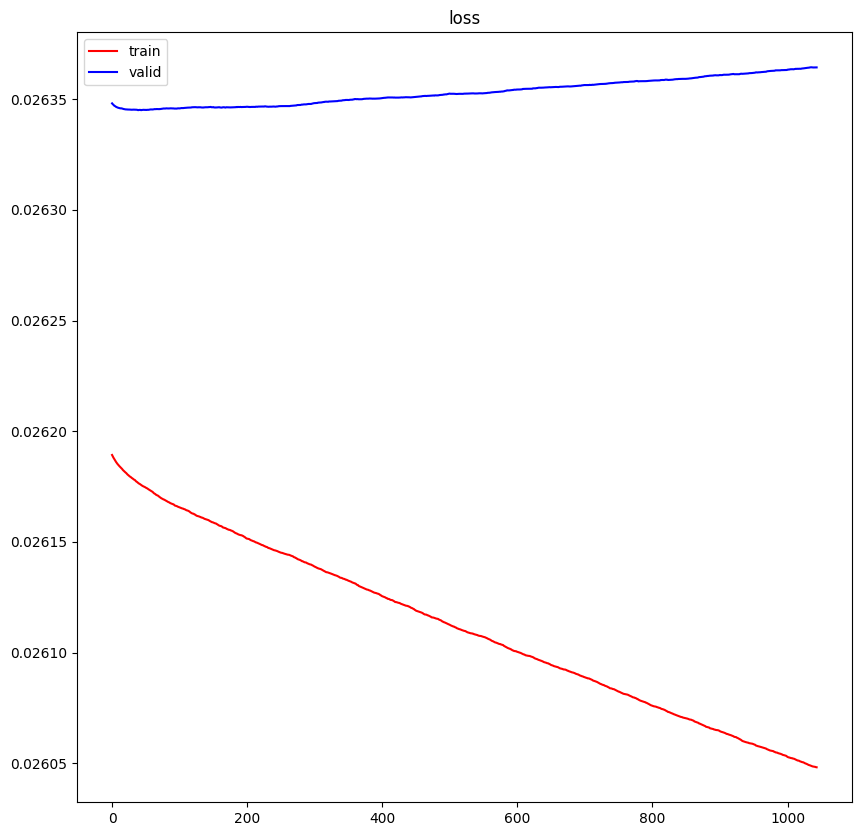

In [41]:
import matplotlib.pyplot as plt
train_loss=list(evals_result['training'].values())[0]
valid_loss=list(evals_result['valid_1'].values())[0]
x_scale=[i for i in range(len(train_loss))]
plt.figure(figsize=(10,10))
plt.title('loss')
plt.plot(x_scale,train_loss,label='train',color='r')
plt.plot(x_scale,valid_loss,label='valid',color='b')
plt.legend()
plt.show()


In [24]:
y_pred

array([0.00018876, 0.00022434, 0.00011108, ..., 0.00076553, 0.00036535,
       0.00030588])

In [25]:
print(math.sqrt(mean_squared_error(y_pred,test.Target)))

0.025912137193322568


## Evaluate Function ##

In [42]:
def calc_spread_return_per_day(df, portfolio_size=200, toprank_weight_ratio=2):
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size=200, toprank_weight_ratio=2):
    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio#, buf

def add_rank(df):
    df["Rank"] = df.groupby("Date")["Target"].rank(ascending=False, method="first") - 1 
    df["Rank"] = df["Rank"].astype("int")
    return df

def fill_nan_inf(df):
    df = df.fillna(0)
    df = df.replace([np.inf, -np.inf], 0)
    return df

def check_score(df,preds,Securities_filter=[]):
    tmp_preds=df[['Date','SecuritiesCode']].copy()
    tmp_preds['Target']=preds
    
    #Rank Filter. Calculate median for this date and assign this value to the list of Securities to filter.
    tmp_preds['target_mean']=tmp_preds.groupby("Date")["Target"].transform('median')
    tmp_preds.loc[tmp_preds['SecuritiesCode'].isin(Securities_filter),'Target']=tmp_preds['target_mean']
    
    tmp_preds = add_rank(tmp_preds)
    df['Rank']=tmp_preds['Rank']
    score=round(calc_spread_return_sharpe(df, portfolio_size= 200, toprank_weight_ratio= 2),5)
    score_mean=round(df.groupby('Date').apply(calc_spread_return_per_day, 200, 2).mean(),5)
    score_std=round(df.groupby('Date').apply(calc_spread_return_per_day, 200, 2).std(),5)
    print(f'Competition_Score:{score}, rank_score_mean:{score_mean}, rank_score_std:{score_std}')
    

In [43]:
check_score(test,y_pred)

Competition_Score:0.13008, rank_score_mean:0.15936, rank_score_std:1.22507


## Submission ##

In [ ]:
sample_submission = pd.read_csv(f"{base_dir}/example_test_files"+'/sample_submission.csv',parse_dates=["Date"])
sample_submission.head()

In [ ]:
list_spred_h=list((train.groupby('SecuritiesCode')['Target'].max()-train.groupby('SecuritiesCode')['Target'].min()).sort_values()[:2000].index)
list_spred_l=list((train.groupby('SecuritiesCode')['Target'].max()-train.groupby('SecuritiesCode')['Target'].min()).sort_values()[-2000:].index)

In [ ]:
len(list_spred_h),len(list_spred_l)

In [ ]:
import os
os.chdir("D:/2023springcourses/CS6665/cs6665 course project/jpx-tokyo-stock-exchange-prediction")

In [ ]:
import jpx_tokyo_market_prediction

env = jpx_tokyo_market_prediction.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test files
for (prices, _, _, _, _, sample_prediction) in iter_test:  
    prices =featureing(prices)
    prices['Target'] = model.predict(fill_nan_inf(prices)[features])
    prices['target_mean']=prices.groupby("Date")["Target"].transform('median')
    prices.loc[prices['SecuritiesCode'].isin(list_spred_h),'Target']=prices['target_mean']
    prices = add_rank(prices)
    sample_prediction['Rank'] = prices['Rank']
    env.predict(sample_prediction)

In [ ]:
sample_prediction.head()